In [10]:
import qmcpy as qp
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import cProfile
import pstats

This below is the definitions of the different functions that will be tested. You can see that there is a normal version of the function and a process version. The process version used multiprocessing.

In [11]:
def natural(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural" ,is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def natural_process(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural_process",is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def mps(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps" ,is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def mps_process(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps_process",is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def linear(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear" ,is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def linear_process(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear_process",is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points


The code measures the execution times of function in the run_list. For each function in the provided list, it iterates through different input dimensions and records the total execution time. These timing results are then organized and added to a DataFrame, creating a structured dataset. By structuring the data in a DataFrame, the script allows for easy analysis and comparison of the execution times for each function with different input dimension.

In [12]:
trials = 2
d_list = [50,100,200,400,800,1600]
n = 1
data = {'index':d_list}
frame = pd.DataFrame(data)
frame = frame.set_index('index')
names = set()

#list contiants the function and a string of its name
run_list = [(natural, "natural"),(natural_process,"natural process"),(linear, "linear"),(linear_process,"linear process"),(mps,"mps"),(mps_process,"mps process")]

for method,method_name in run_list:

    name = method_name.split(" ")

    names.add(name[0])

    times = []
    
    for d in d_list:
        profiler = cProfile.Profile()
        profiler.enable()
        for _ in range(trials):
            method(d, 2 ** n)
        profiler.disable()
        
        stats = pstats.Stats(profiler)
            
        process_time = stats.total_tt

        
        times.append(process_time)

        
    frame[method_name] = times    
  


names = list(names)  


TypeError: gen_block_points() missing 1 required positional argument: 'gen_vec'

This speed_up_cal function takes in the two specificed funcitons in the tuple list and compares them, calulating a speed up factor. Then the result of this is put into the original data frame.

In [ ]:
compare_methods= [('natural', 'natural process'),('mps', 'mps process'),('linear', 'linear process')]


def speed_up_cal(data_frame, compare_list, dimension_list):
    result = []
    for seq,pro in compare_list:
        result = []
        for x in dimension_list:
            a = data_frame[seq][x]
            b = data_frame[pro][x]
            result.append(a/b)
        data_frame[seq + " speed-up"] = result


speed_up_cal(frame, compare_methods, d_list)







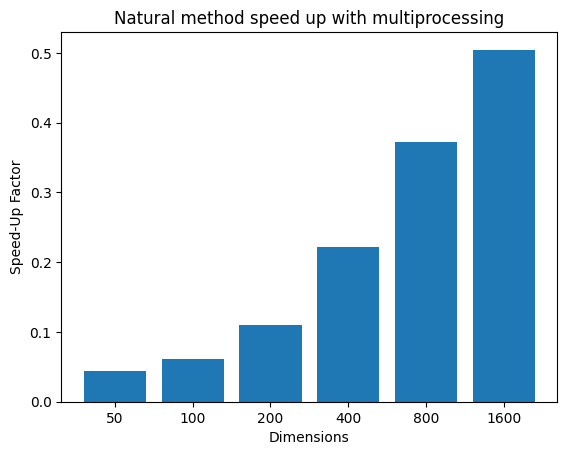

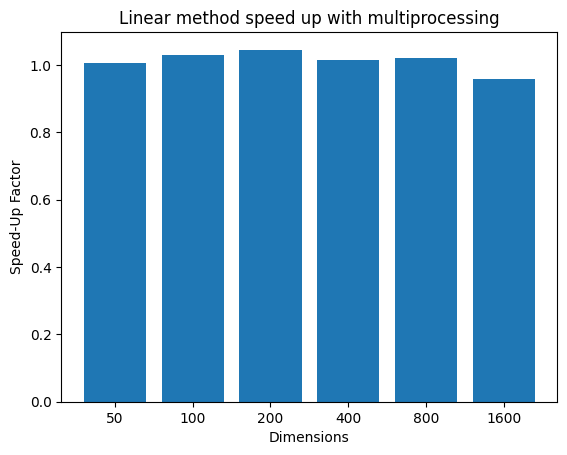

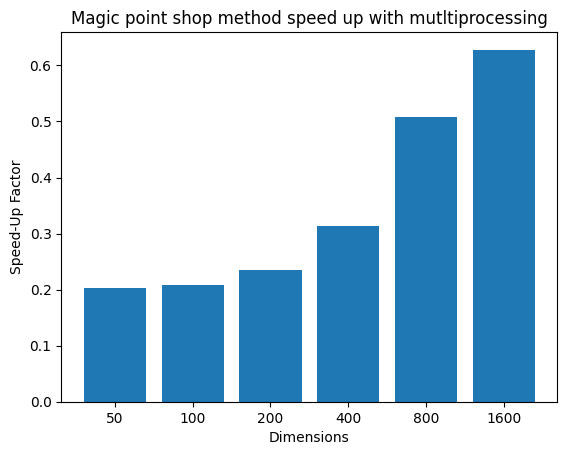

In [ ]:

x = lambda array: [str(x) for x in array]

y_axis = frame["natural speed-up"].to_numpy()
x_axis = x(d_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('Natural method speed up with multiprocessing')
#plt.xticks(np.arange(1,len(d_list),2))
plt.show()


y_axis = frame["linear speed-up"].to_numpy()
x_axis = x(d_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('Linear method speed up with multiprocessing')
#plt.xticks(np.arange(1,len(d_list),2))
plt.show()

y_axis = frame["mps speed-up"].to_numpy()
x_axis = x(d_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('Magic point shop method speed up with mutltiprocessing')
plt.show()

In [ ]:
p_list = [2**x for x in range(5,15)]
dimension = 100
records = {'index':p_list}
frame2 = pd.DataFrame(records)
frame2 = frame2.set_index('index')
names = set()

for method, method_name in run_list:
    name = method_name.split(" ")

    names.add(name[0])


    times = []
    
    for p in p_list:
        profiler = cProfile.Profile()
        profiler.enable()
        for _ in range(trials):
            method(d, p)
        profiler.disable()
    
        stats = pstats.Stats(profiler)
        
        process_time = stats.total_tt

        
        times.append(process_time)
    
    frame2[method_name] = times   
      


names = list(names)  
speed_up_cal(frame2,compare_methods, p_list)   

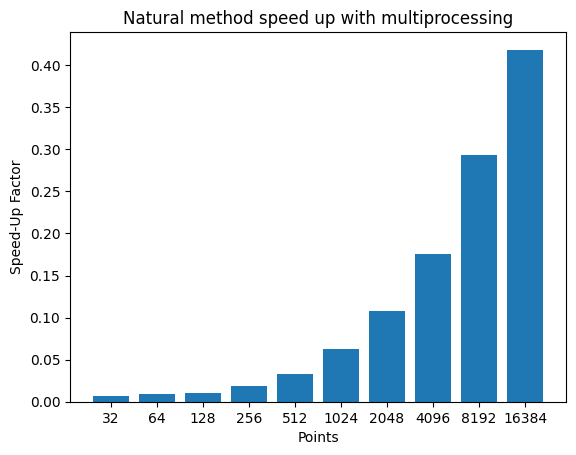

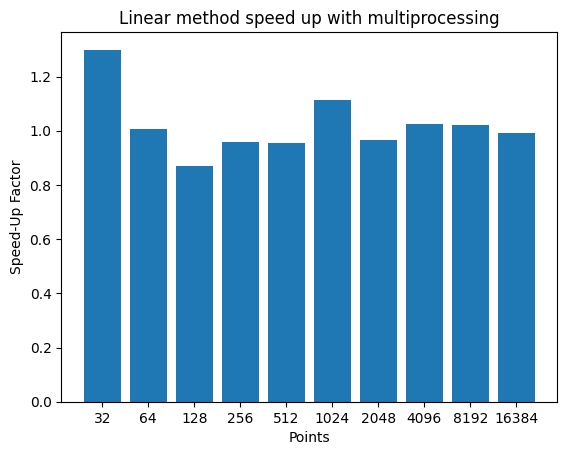

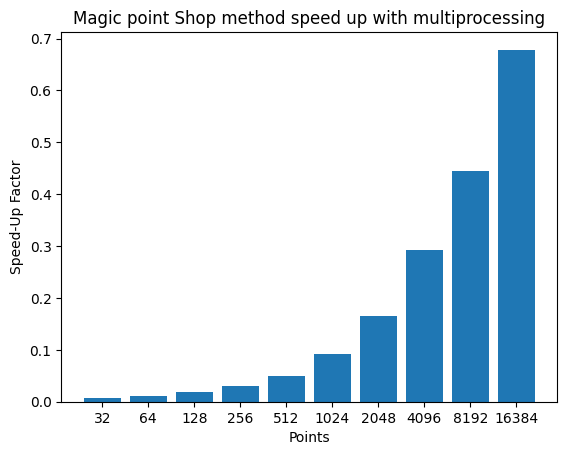

In [ ]:
x = lambda array: [str(x) for x in array]

y_axis = frame2["natural speed-up"].to_numpy()
x_axis = x(p_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Points')
plt.ylabel('Speed-Up Factor')
plt.title('NONE')
plt.title('Natural method speed up with multiprocessing')
plt.show()

y_axis = frame2["linear speed-up"].to_numpy()
x_axis = x(p_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Points')
plt.ylabel('Speed-Up Factor')
plt.title('Linear method speed up with multiprocessing')
plt.show()

y_axis = frame2["mps speed-up"].to_numpy()
x_axis = x(p_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Points')
plt.ylabel('Speed-Up Factor')
plt.title('Magic point Shop method speed up with multiprocessing')
plt.show()